# Weighted metrics computation

In this notebook, we measure the weighted metrics on different datasets and see if the WIFS paper results still hold.
The datasets are

- Scanner dataset run 1
- Iphone dataset run 1-6
- Samsung dataset run 1-6


## Libraries

In [2]:
import numpy as np
from lib.Dataset_cdp import DatasetCDP
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve, roc_auc_score
import json
from tqdm import tqdm

from lib.predictor_functions import batch_train_codebook, pool_predict, apply_otsu_threshold
from lib.cdp_metrics import batch_metric


In [12]:
t = np.ones([3,64,64])
a = np.array_split(t,3)

In [22]:
a = np.random.random(5)

In [25]:
b = (a < .5)
c = np.ma.array(a, mask=b)

In [26]:
np.array_split(c,2)

[masked_array(data=[--, 0.6418693356218845, --],
              mask=[ True, False,  True],
        fill_value=1e+20),
 masked_array(data=[0.6795263034144925, --],
              mask=[False,  True],
        fill_value=1e+20)]

## Parameters

In [19]:
nb_train = 50
nb_test = 500
processing = 'hist_match' # 'no_processing', 'normalize', 'stretch' or 'hist_match'
enroll = 'samsung' # 'iphone', 'samsung' or 'scanner'
authenticate = 'samsung'
estimator = 'otsu'
run = 1
seed = 0
use_unet = False

poolsize = 50

metrics = ['lls', 'dhamm', 'mse', 'l1', 'pcor']
thresholds = np.concatenate([k * np.arange(1,10) for k in [1e-4, 1e-3, 1e-2, 1e-1]])
thresholds = np.append(thresholds, [1])

matplotlib.rcParams.update({'font.size': 20})

## Load dataset

Define the parameters of the run

In [20]:
assert enroll in {'iphone', 'samsung'}, print(f'{enroll} is not a valid choice of acquisition system !')
assert authenticate in {'iphone', 'samsung'}, print(f'{enroll} is not a valid choice of acquisition system !')

if processing == 'hist_match':
    hist_match = True
else:
    hist_match = False

dset = DatasetCDP(dataset_name=enroll, run=run, nb_samples=1440, load_unet=use_unet, normalized=False, hist_match=hist_match)
dset_auth = DatasetCDP(dataset_name=authenticate, run=run, nb_samples=1440, load_unet=use_unet, normalized=False, hist_match=hist_match)

In [4]:
loader = DataLoader(dset, batch_size=len(dset), shuffle=False)
loader_auth = DataLoader(dset_auth, batch_size=len(dset_auth), shuffle=False)

for data in loader:
    for key in data.keys():
        data[key] = np.asarray(data[key])

if enroll == authenticate:
    data_auth = data

else:
    for data_auth in loader_auth:
        for key in data_auth.keys():
            data_auth[key] = np.asarray(data_auth[key])

In [5]:
possible_choices = list(np.arange(len(dset)))

np.random.seed(seed)
random_perm = np.random.permutation(possible_choices)
print(random_perm[:nb_train])

[ 308  152  875  503  351   18 1001 1095  995  933 1068  528    5 1140
 1064   45  465 1023  869  270  298  412 1081 1037  311  814  202  837
  856   52 1212  828  839  569  794  361   55 1024  161  141  686  443
    1  283 1048 1005  156  746  535  764]


In [6]:
data_train = {}
data_test = {}

for key in data.keys():
    data_train[key] = data[key][random_perm[:nb_train]]

for key in data_auth.keys():
    data_test[key] = data_auth[key][random_perm[nb_train:nb_train+nb_test]]

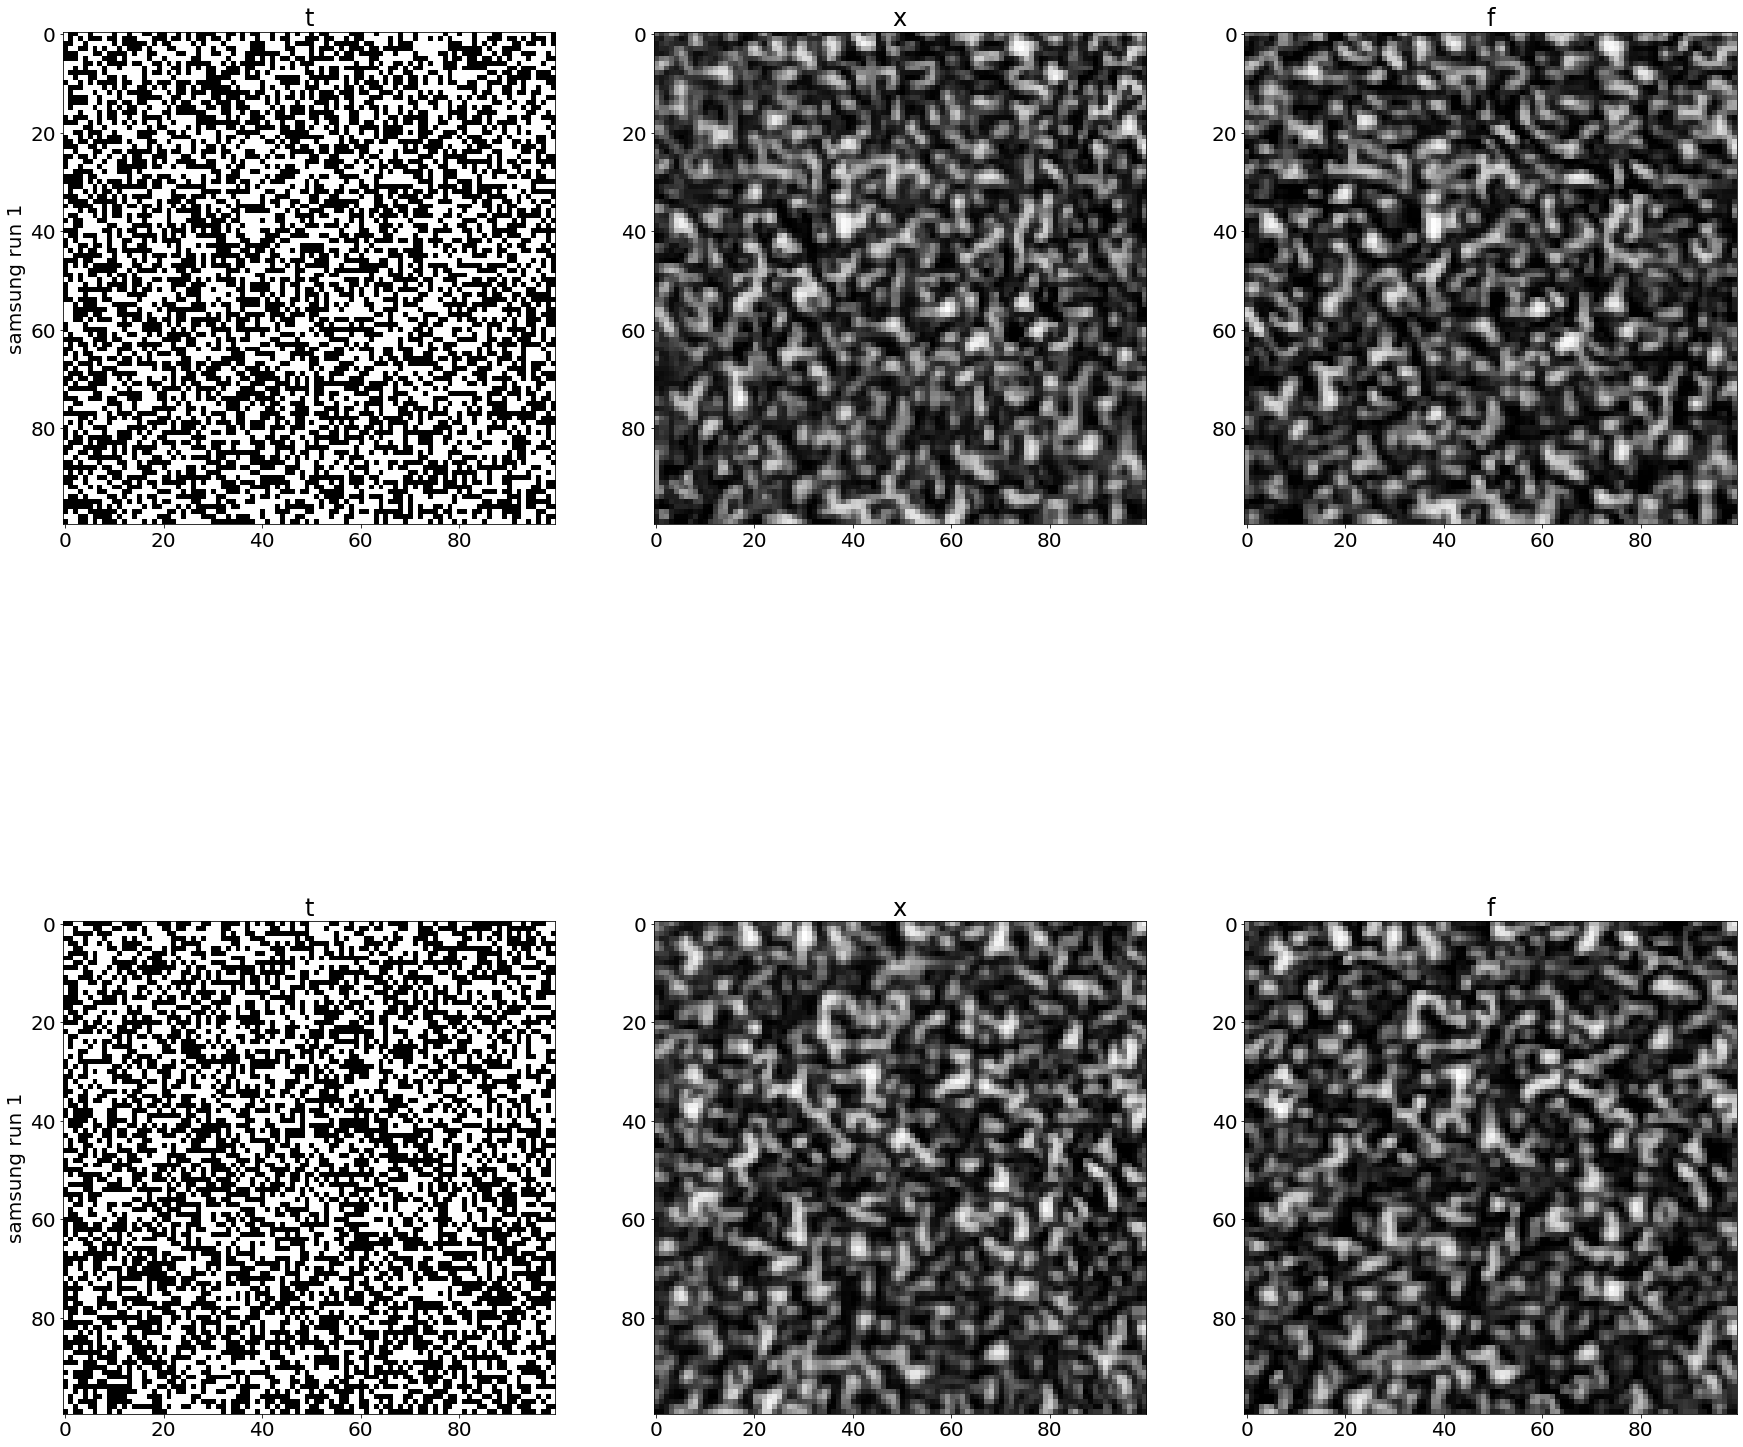

In [8]:
plt.figure(figsize=(30,30))

limit = 100
i = 1

for name in data_train.keys():
    plt.subplot(2, len(data_train.keys()), i)
    plt.imshow(data_train[name][0, limit:2*limit, limit:2*limit], cmap='gray')
    if i == 1:
        plt.ylabel(f'{enroll} run {run}')
    plt.title(name)
    i += 1

for name in data_test.keys():
    plt.subplot(2, len(data_train.keys()), i)
    plt.imshow(data_test[name][0, limit:2*limit, limit:2*limit], cmap='gray')
    if i == 4:
        plt.ylabel(f'{authenticate} run {run}')
    plt.title(name)
    i += 1

plt.show()

## Train model

In [10]:
local_prob_x, _ = batch_train_codebook((data_train['t'] > .5), data_train['x'], poolsize=10, estimator=estimator, block_size=1)

In [11]:
hist_x = []

for i in range(512):
    code = bin(i)[2:].zfill(9)
    hist_x += [local_prob_x['error'][code]]

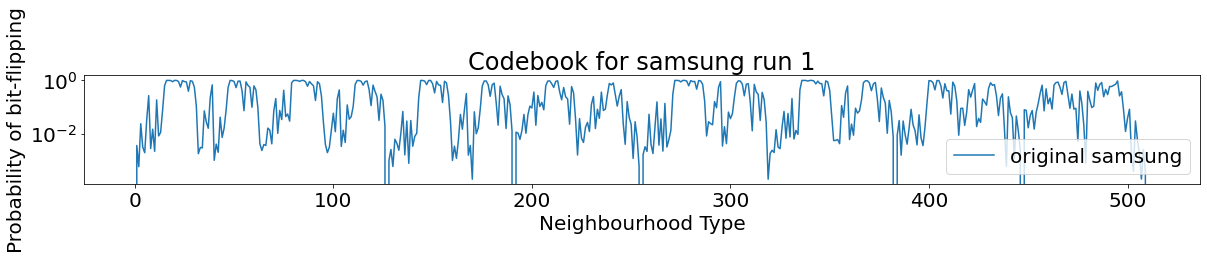

In [12]:
plt.figure(figsize=(20,2))
plt.title(f'Codebook for {enroll} run {run}')
plt.plot(hist_x, label=f'original {enroll}')
plt.yscale('log')
plt.xlabel('Neighbourhood Type')
plt.ylabel('Probability of bit-flipping')
plt.legend()
plt.show()

## Apply to the dataset

In [13]:
if estimator == 'otsu':
    data_test['t_x'] = apply_otsu_threshold(data_test['x'], block_size=1)
    data_test['t_f'] = apply_otsu_threshold(data_test['f'], block_size=1)

data_test[f't_pred_x'], data_test['biterror_pred_x'] = pool_predict(data_test['t'] > .5, local_prob_x, poolsize=10)

100%|██████████| 500/500 [00:00<00:00, 1647.79it/s]


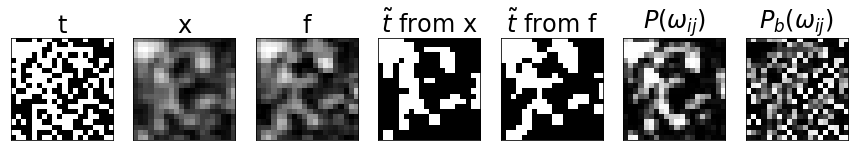

In [14]:
plt.figure(figsize=(15,5))

L = 20
i = 1

labels = ['t', 'x', 'f', r'$\tilde{t}$ from x', r'$\tilde{t}$ from f', r'$P(\omega_{ij})$', r'$P_b(\omega_{ij})$']

for name in ['t', 'x', 'f', 't_x', 't_f', 't_pred_x', 'biterror_pred_x']:
    plt.subplot(1, 7, i)
    plt.imshow(data_test[name][0, L:2*L, L:2*L], cmap='gray')
    plt.title(labels[i-1])
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.show()

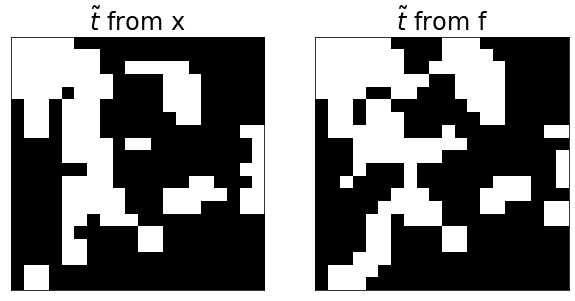

In [15]:
plt.figure(figsize=(10,6))

i = 1

labels = [r'$\tilde{t}$ from x', r'$\tilde{t}$ from f']

for name in ['t_x', 't_f']:
    plt.subplot(1, 2, i)
    plt.imshow(data_test[name][0, L:2*L, L:2*L], cmap='gray')
    plt.title(labels[i-1])
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.show()

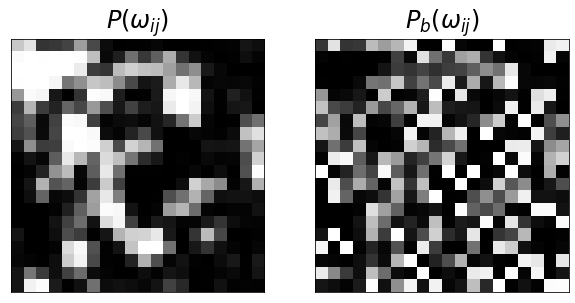

In [16]:
plt.figure(figsize=(10,5))

i = 1

labels = [r'$P(\omega_{ij})$', r'$P_b(\omega_{ij})$']

for name in [f't_pred_x', f'biterror_pred_x']:
    plt.subplot(1,2, i)
    plt.imshow(data_test[name][0, L:2*L, L:2*L], cmap='gray')
    plt.title(labels[i-1])
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.show()

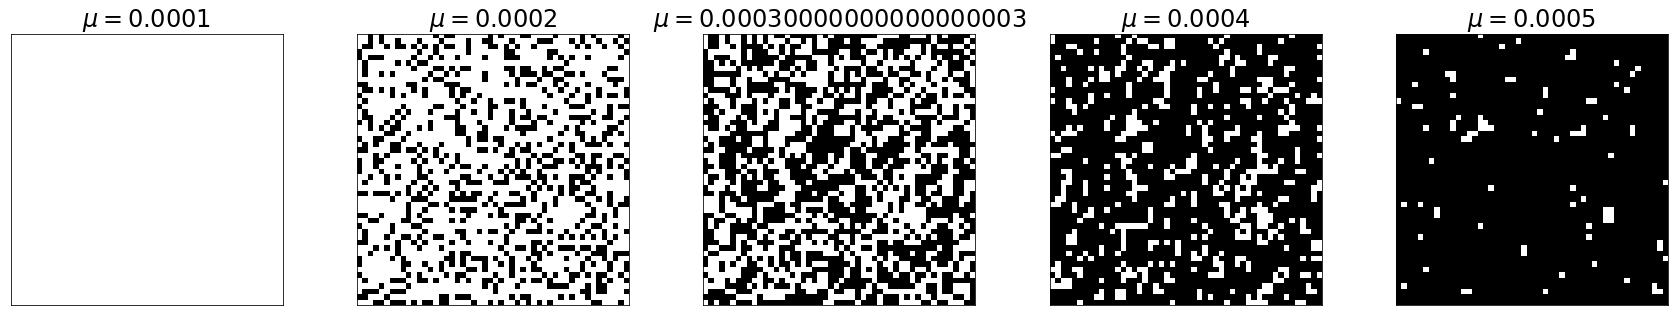

In [17]:
plt.figure(figsize=(30,5))

L = 50
i = 1

labels = [fr'$\mu={t}$' for t in thresholds]

for t in [1, 0.5, 0.1, 0.01, 0.001]:
    plt.subplot(1, 5, i)
    plt.imshow(data_test['biterror_pred_x'][0, L:2*L, L:2*L] <= t, cmap='gray', vmin=0, vmax=1)
    plt.title(labels[i-1])
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.show()

## Weight metrics

Define a dictionary with all possible metrics

In [13]:
measures = {metric: {} for metric in metrics}
roc_curves = {metric: {} for metric in metrics}
roc_auc_scores = {metric: {} for metric in metrics}

for metric in metrics:
    for t in thresholds:
        measures[metric][round(t,8)] = {'x': [], 'f': []}
        roc_curves[metric][round(t,8)] = []

### Measure the metrics

In [5]:
{0.1 : [], 0.2 : [], 0.004 : []}

{0.1: [], 0.2: [], 0.004: []}

In [54]:
print(f'Metrics to compute : {len(metrics)}')

if processing == 'hist_match':
    mode = 'no_processing'
else:
    mode = processing

for metric in metrics:
    for key in ['x', 'f']:
        print(f'Computing {metric} {key}')
        for t in tqdm(thresholds):

            if metric == 'lls':
                batch_t = data_test['t_pred_x']
                batch_y = data_test[f't_{key}']

            elif metric == 'dhamm':
                batch_t = (data_test['t'] > .5)
                batch_y = data_test[f't_{key}']

            else:
                batch_t = data_test['t']*1
                batch_y = data_test[key]

            measures[metric][f'thresh_{t}'][key] = np.asarray(batch_metric(batch_t, batch_y, metric, 1, np.logical_and(data_test['biterror_pred_x'] < t, data_test['biterror_pred_x'] > 1e-5), mode))


Metrics to compute : 5
Computing lls x


100%|██████████| 37/37 [00:30<00:00,  1.22it/s]


Computing lls f


100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


Computing dhamm x


100%|██████████| 37/37 [00:06<00:00,  5.77it/s]


Computing dhamm f


100%|██████████| 37/37 [00:06<00:00,  5.69it/s]


Computing mse x


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]


Computing mse f


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]


Computing l1 x


100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Computing l1 f


100%|██████████| 37/37 [00:09<00:00,  3.80it/s]


Computing pcor x


100%|██████████| 37/37 [00:58<00:00,  1.58s/it]


Computing pcor f


100%|██████████| 37/37 [00:58<00:00,  1.58s/it]


In [55]:
roc_curves = {metric: {} for metric in metrics}
roc_auc_scores = {metric: {} for metric in metrics}

for metric in metrics:
    for t in thresholds:
        roc_curves[metric][f'thresh_{t}'] = []


for metric in metrics:
    y_true = np.concatenate([np.ones(nb_test), np.zeros(nb_test)])

    for thresh in measures[metric].keys():
        score = np.concatenate([measures[metric][thresh]['x'], measures[metric][thresh]['f']])
        fpr, tpr, gamma = roc_curve(y_true, score)
        if metric != 'pcor':
            roc_curves[metric][thresh] = (1-fpr, 1-tpr, gamma)
        else:
            roc_curves[metric][thresh] = (fpr, tpr, gamma)

        roc_auc_scores[metric][thresh] = roc_auc_score(y_true, score)

In [56]:
measures_json = {metric: {} for metric in metrics}
roc_curves_json = {metric: {} for metric in metrics}

for metric in metrics:
    for t in thresholds:
        measures_json[metric][f'thresh_{t}'] = {'x': [], 'f': []}
        roc_curves_json[metric][f'thresh_{t}'] = []

for metric in metrics:
    for thresh in measures[metric].keys():
        measures_json[metric][thresh] = {'x': [], 'f': []}
        roc_curves_json[metric][thresh] = []

        measures_json[metric][thresh]['x'] = measures[metric][thresh]['x'].tolist()
        measures_json[metric][thresh]['f'] = measures[metric][thresh]['f'].tolist()

        fpr, tpr, gamma = roc_curves[metric][thresh]
        roc_curves_json[metric][thresh] = (fpr.tolist(), tpr.tolist(), gamma.tolist())

In [22]:
path = f'TIFS_train_{enroll}_test_{authenticate}_run_{run}_estimator_{estimator}_processing_{processing}_seed_{seed}'

with open(f'results/metrics/measures_data/{path}.json', "w") as fp:
    json.dump(measures_json, fp)

with open(f'results/metrics/roc_curves_data/{path}.json', "w") as fp:
    json.dump(roc_curves_json, fp)
    
with open(f'results/metrics/roc_curves_data/{path}_auc.json', "w") as fp:
    json.dump(roc_auc_scores, fp)


### Visualize results

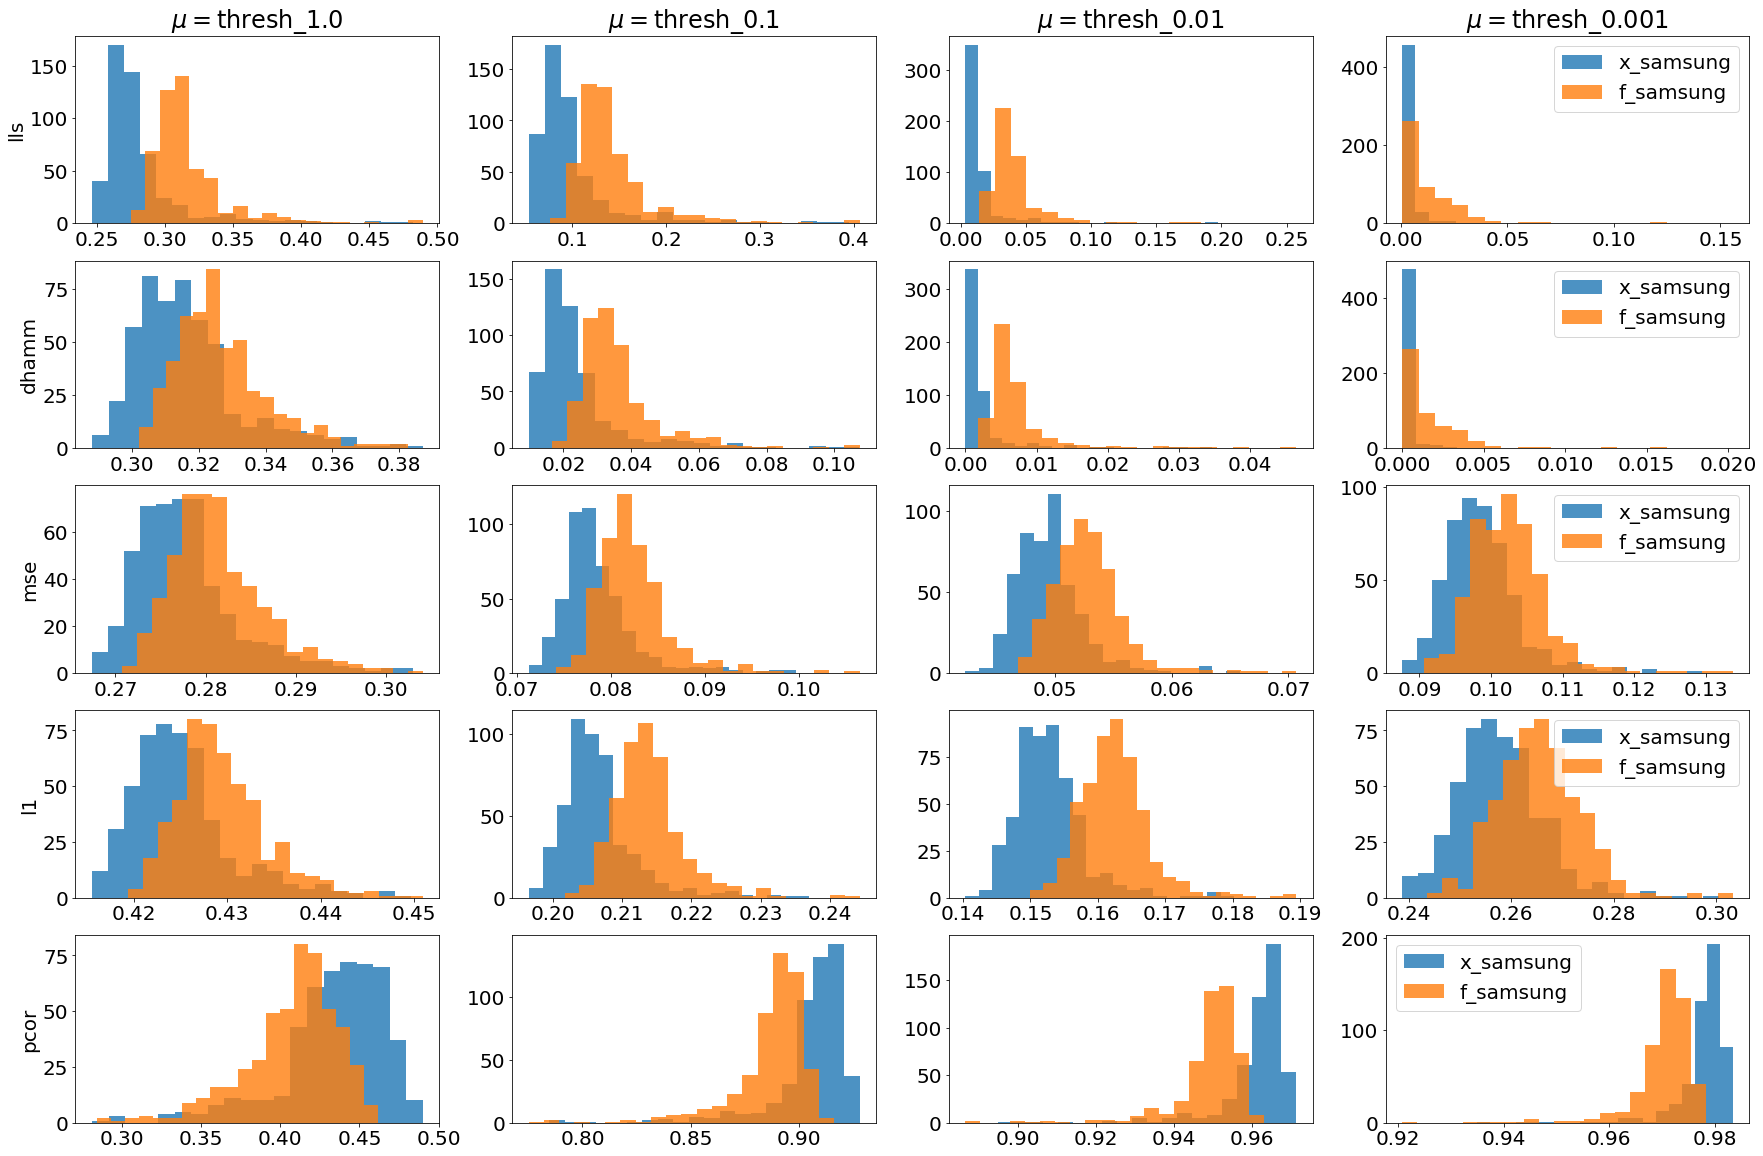

In [57]:
chosen_thresholds = ['thresh_1.0', 'thresh_0.1', 'thresh_0.01', 'thresh_0.001']

plt.figure(figsize=(30,20))

i = 1

for metric in metrics:
    for thresh in chosen_thresholds:
        plt.subplot(len(metrics), len(chosen_thresholds), i)
        plt.hist(measures[metric][thresh]['x'], label=f'x_{authenticate}', alpha=.8, bins=20)
        plt.hist(measures[metric][thresh]['f'], label=f'f_{authenticate}', alpha=.8, bins=20)
        if i <= len(chosen_thresholds):
            plt.title(r'$\mu = $' + f'{chosen_thresholds[i-1]}')
    
        if i-1 in range(0, len(chosen_thresholds)*len(metrics), len(chosen_thresholds) ):
            plt.ylabel(metrics[i//len(chosen_thresholds)])

        i += 1
    
    plt.legend()

plt.show()

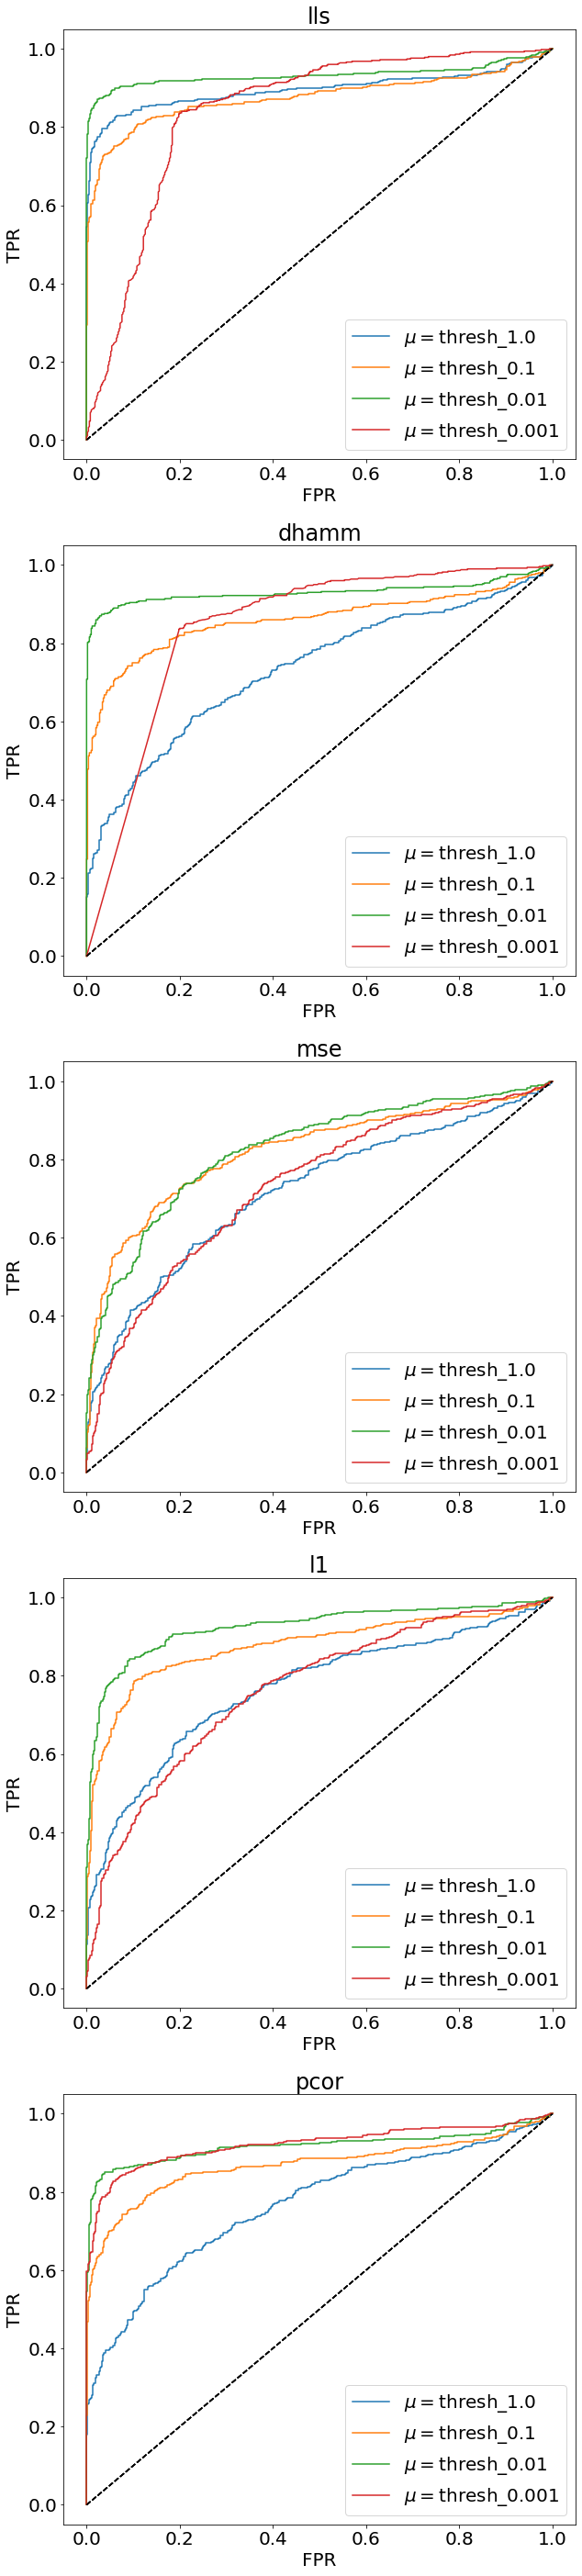

In [58]:
plt.figure(figsize=(10,50))

i = 0

for metric in metrics:
    for thresh in chosen_thresholds:
    
        fpr, tpr, gamma = roc_curves[metric][thresh]
    
        plt.subplot(len(metrics), 1, i // len(chosen_thresholds) + 1)
        plt.title(metrics[i // len(chosen_thresholds)])
        plt.plot(fpr, tpr, label=r'$\mu = $' + f'{chosen_thresholds[i % len(chosen_thresholds)]}')
        plt.plot([0,1], [0,1], 'k--')
        i += 1
        plt.legend()
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid(which='both')

plt.show()

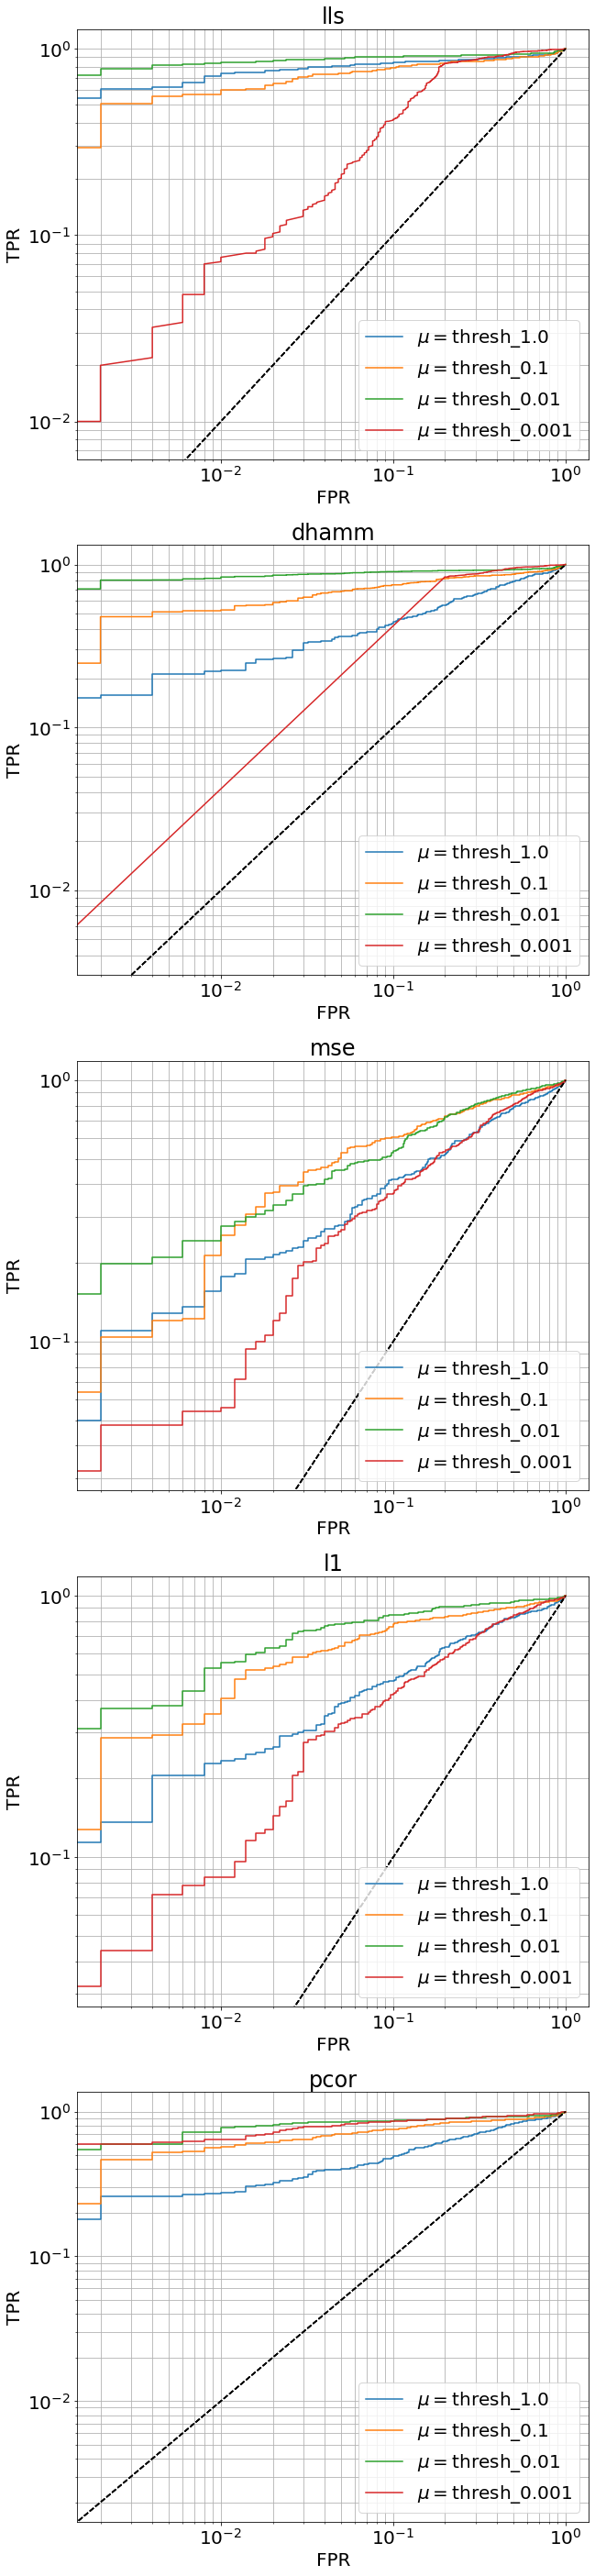

In [59]:
plt.figure(figsize=(10,50))

i = 0

for metric in metrics:
    for thresh in chosen_thresholds:

        fpr, tpr, gamma = roc_curves[metric][thresh]

        plt.subplot(len(metrics), 1, i // len(chosen_thresholds) + 1)
        plt.title(metrics[i // len(chosen_thresholds)])
        plt.loglog(fpr, tpr, label=r'$\mu = $' + f'{chosen_thresholds[i % len(chosen_thresholds)]}')
        plt.loglog([0,1], [0,1], 'k--')
        i += 1

    plt.legend()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(which='both')

plt.show()

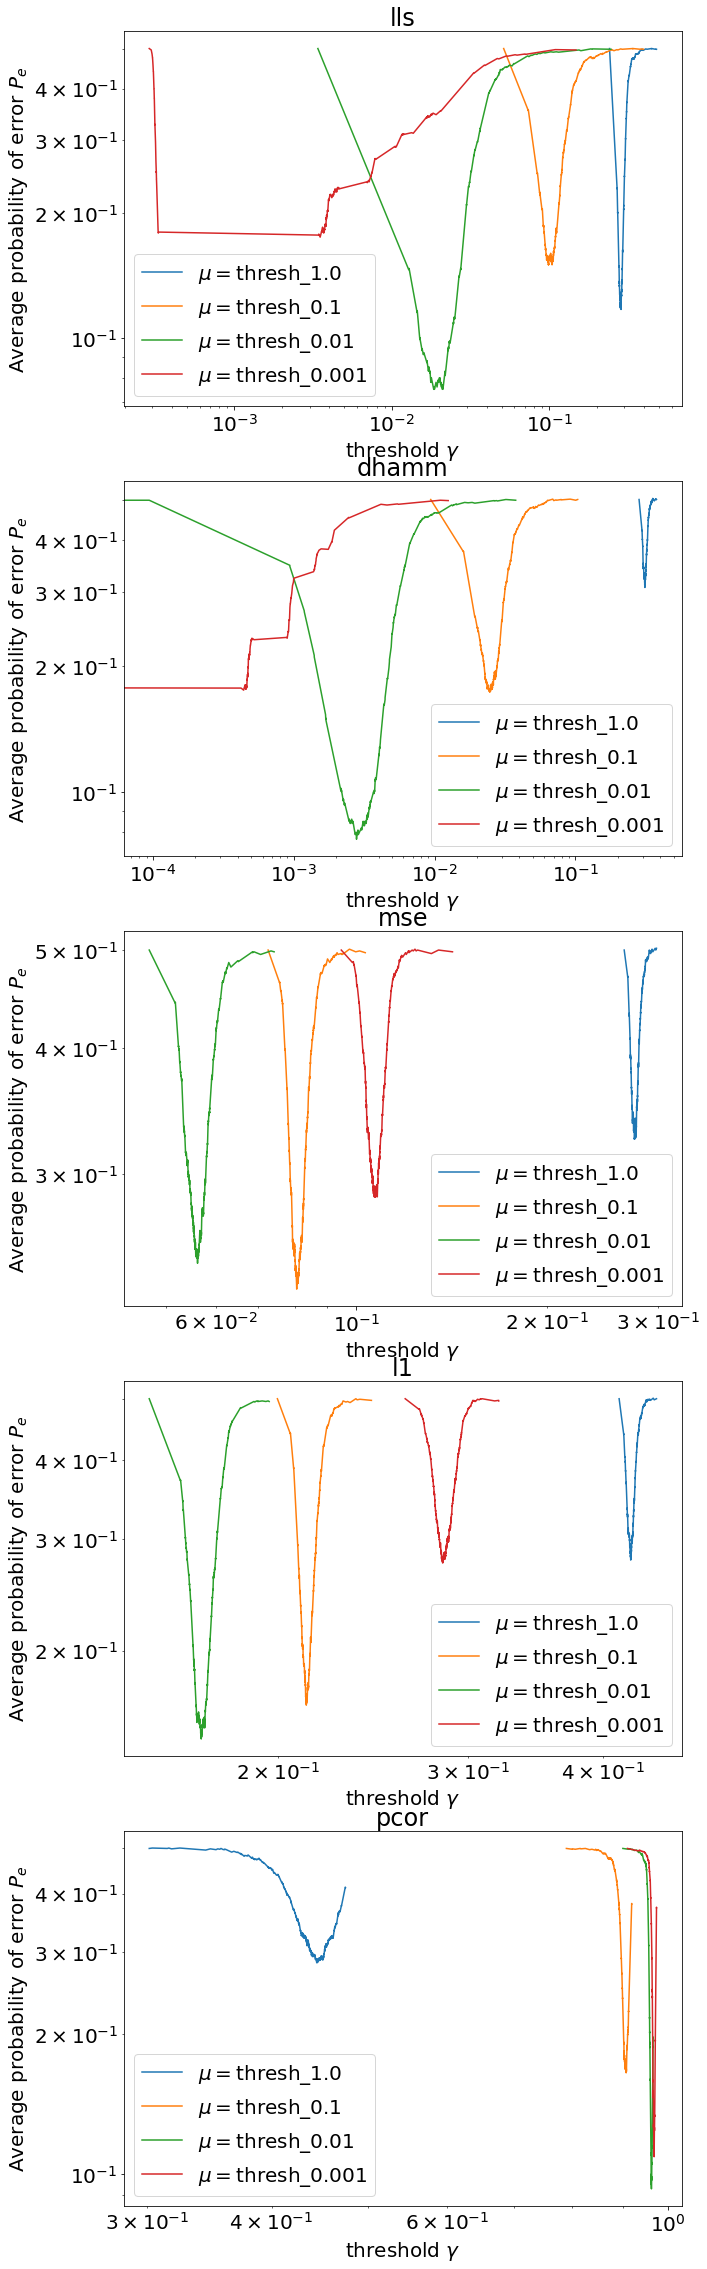

In [26]:
plt.figure(figsize=(10,40))

i = 0

for metric in metrics:

    p_err_general = []

    for thresh in chosen_thresholds:
    
        fpr, tpr, gamma = roc_curves[metric][thresh]

        p_error = (1 + fpr - tpr) / 2

        p_err_general.append(p_error.min())

        plt.subplot(len(metrics), 1, i // len(chosen_thresholds) + 1)
        plt.title(metrics[i // len(chosen_thresholds)])
        plt.plot(gamma[2:], p_error[2:], label=r'$\mu = $' + f'{chosen_thresholds[i % len(chosen_thresholds)]}')
        plt.grid(which='both')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel(r'threshold $\gamma$')
        plt.ylabel(r'Average probability of error $P_e$')
        plt.legend()

        i+=1

plt.show()


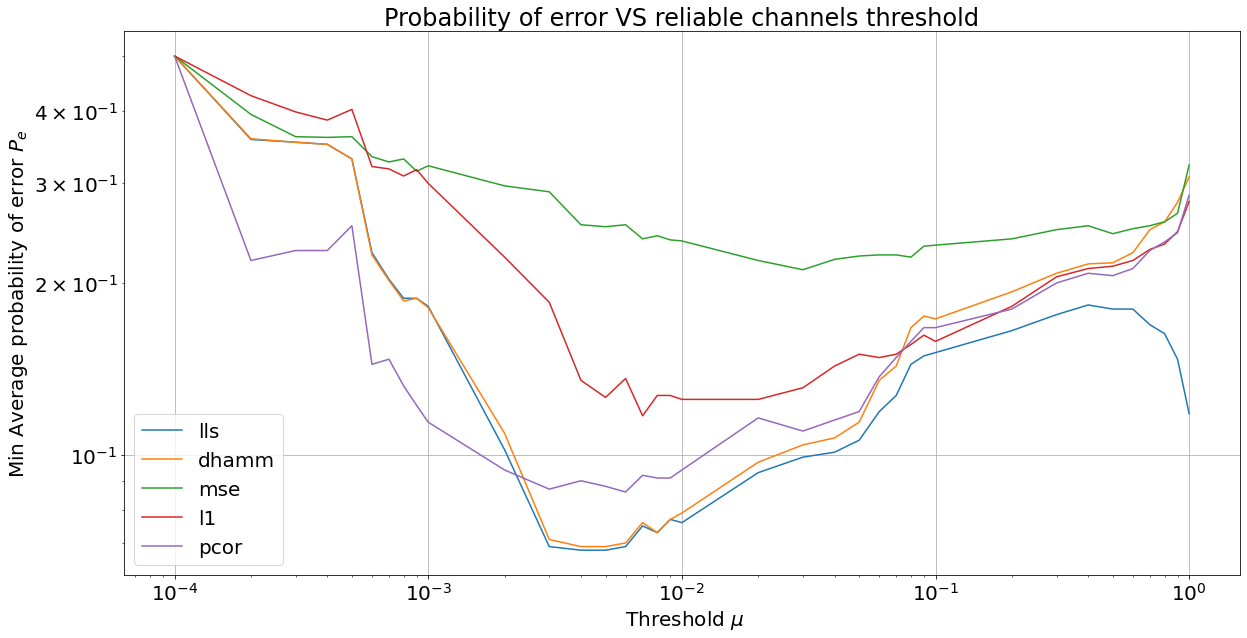

In [60]:
plt.figure(figsize=(20, 10))

i = 0

plt.title('Probability of error VS reliable channels threshold')

for metric in metrics:

    p_err_general = []

    for thresh in measures[metric].keys():
        fpr, tpr, gamma = roc_curves[metric][thresh]

        p_error = (1 + fpr - tpr) / 2

        p_err_general.append(p_error.min())

    plt.loglog(thresholds, p_err_general, label=metric)
    i += 1

plt.xlabel(r' Threshold $\mu$')
plt.ylabel(r'Min Average probability of error $P_e$')
plt.grid()
plt.legend()
plt.show()